In [ ]:
from __future__ import division, print_function, absolute_import
import numpy as np
from numpy import sqrt, pi, cos, sin, log, exp, sinh
from phidl import Device, Layer, LayerSet, device_layout, Path, CrossSection, Device
from phidl import quickplot as qp
import phidl.geometry as pg
import phidl.routing as pr
import phidl.utilities as pu
import phidl.path as pp
from phidl import quickplot as qp
import bezier
import math
import sys
import os
import math
sys.path.append(os.path.abspath(r"/Users/kamilakunes/Desktop/PhDwork/Chunho_lib_240919"))
from Chunho_lib_111723_airsuspended import *
from Chunho_lib_111723_electrodes import *
from Chunho_lib_111723_heaters import *
from Chunho_lib_111723_markers import *
from Chunho_lib_111723_waveguides import *
from Chunho_lib_111723_greyscale import *


In [ ]:
ls = LayerSet() # Create a blank LayerSet
ls.add_layer(name = 'label', gds_layer = 1, gds_datatype = 0,
             description = 'General label', color = 'deeppink')
ls.add_layer(name = 'marker', gds_layer = 2, gds_datatype = 0,
             description = 'EBL marker', color = 'firebrick')
ls.add_layer(name = 'grating', gds_layer = 3, gds_datatype = 0,
             description = 'bragg_grating', color = 'darkturquoise')
ls.add_layer(name = 'wg', gds_layer = 4, gds_datatype = 0,
             description = 'LN wg', color = 'dodgerblue')
ls.add_layer(name = 'ring', gds_layer = 5, gds_datatype = 0,
             description = 'LN ring', color = 'deepskyblue')
ls.add_layer(name = 'gold1', gds_layer = 6, gds_datatype = 0,
             description = 'Gold electrode', color = 'gold')
ls.add_layer(name = 'via', gds_layer = 7, gds_datatype = 0,
             description = 'hole', color = 'grey')
ls.add_layer(name = 'gold2', gds_layer = 8, gds_datatype = 0,
             description = '2nd Gold electrode', color = 'goldenrod')
ls.add_layer(name = 'nicr', gds_layer = 9, gds_datatype = 0,
             description = 'heater', color = (0.4,0.5,0.7))
ls.add_layer(name = 'test', gds_layer = 10, gds_datatype = 0,
             description = 'alignment', color = 'lime')
ls.add_layer(name = 'mc', gds_layer = 11, gds_datatype = 0,
             description = 'mode converter', color = 'mediumblue')
ls.add_layer(name = 'detch', gds_layer = 12, gds_datatype = 0,
             description = 'deep etch', color = 'orangered')
ls.add_layer(name = 'pcm', gds_layer = 13, gds_datatype = 0,
             description = 'pcm', color = 'orangered')

pu.write_lyp('my_layer_properties_file.lyp', layerset = ls)

layer_label =  ls['label']
layer_marker = ls['marker']
layer_grating = ls['grating']
layer_wg = ls['wg']
layer_ring = ls['ring']
layer_metal = ls['gold1']
layer_via = ls['via']
layer_metal2 = ls['gold2']
layer_heater = ls['nicr']
layer_test = ls['test']
layer_MC = ls['mc'] # increase gap to 1mm
layer_Detch = ls['detch']
layer_pcm = ls['pcm']

In [ ]:
# parameters
radius_wg = 100
wg_single = 0.8
wg_dc_bus=1
wg_pulley_bus=0.8
wg_mod = 2.0
taperlength1 = 100 #General tapering

# stuff i guess i need
facet_width1=3
pad_w=150
signal_body_w=50
gap_body1=3.7
edge_width1=6.5
edge_width2=0.5
gap_body2=gap_body1+(edge_width1+edge_width2)*2
mod_l = 50
y_splitter_length=200
y_splitter_output_length = 50


Tring_wgcp1 = np.array([
    [0.7 for x in range(1)],
    [0.8 for x in range(1)],
    [0.9 for x in range(1)],
    [0.95 for x in range(1)],
    [1.0 for x in range(1)],
    [1.1 for x in range(1)]]
)


D = Device()


In [ ]:
# Adjustable parameters

ws = 20 # waveguide spacing to avoid interctions (um)
mrow = 12
mcol = 4
seg_row = 8
pi_len = 5
min_PCM_len = 4

#Facet parameters
facet_length=1000
facet_width=3

# Calculate the width and length of the device
chip_sizex = 15000 # 1.8 cm bbox[1][0] - bbox[0][0]  # x2 - x1
chip_sizey = 6000 # bbox[1][1] - bbox[0][1] - 1000  # y2 - y1


In [ ]:
def straight(width=3, layer = layer_wg, length=100):
        D = Device()
        D << Path().append(pp.straight(length=length)).extrude(width, layer)
        D.add_port(name = "o1", midpoint = [0,0], width = width, orientation = -180)
        D.add_port(name = "o2", midpoint = [length, 0], width = width, orientation = 0)
        return D

def taper(length=200, width1=3, width2=5, layer=layer_wg):
        D = Device()
        t = D << pg.taper(length=length, width1=width1, width2=width2, layer=layer)
        D.add_port(name = "o1", port=t.ports[1])
        D.add_port(name = "o2", port=t.ports[2])
        return D

def facet(device, port, angle, vertical_offset, waveguide_length):
        D = Device()
        # Retrieve the starting point and orientation from the existing device's port
        start_in_port = device.ports[port]
        x1, y1 = start_in_port.midpoint  # Starting point (x1, y1)

        # Calculate the new waveguide's position based on the vertical offset
        pos_x = x1  # Keep the x-position the same as the port's x
        pos_y = vertical_offset  # Offset the y-position

        # Create the new waveguide (not connected to the port)
        f = D << straight(width=facet_width, layer = layer_wg, length=waveguide_length)
        # facet_ref = D.add_ref(f)
        D.rotate(angle=angle)
        D.move((pos_x, pos_y))
        
        D.add_port(name = "f1", port=f.ports["o1"])
        D.add_port(name = "f2", port=f.ports["o2"])
        return D


def connect_with_taper(dev1, port1, dev2, port2, layer=layer_wg):

    D = Device()

    port_1 = dev1.ports[port1]
    port_2 = dev2.ports[port2]

    # Calculate taper parameters based on the ports
    start_width = port_1.width
    
    end_width = port_2.width

    # Calculate the distance between the two ports
    x1, y1 = port_1.midpoint
    x2, y2 = port_2.midpoint
    taper_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Create the taper geometry
    taper = pg.taper(length=taper_length, width1=start_width, width2=end_width, layer=layer)

    # Add the taper to the device
    taper_ref = D.add_ref(taper)

    # Align the taper: first align it with port1
    taper_ref.connect(1, destination=port_1)

    taper_ref.move(origin=taper_ref.ports[2].midpoint, destination=port_2.midpoint)

    # Add ports to the new device to preserve connectivity
    D.add_port(name="tc1", port=taper_ref.ports[1])
    D.add_port(name="tc2", port=taper_ref.ports[2])

    return D

def trapezoid(center_width, height, angle, layer = layer_pcm):
    angle_rad = np.radians(angle)
    
    # Calculate the top and bottom widths
    bottom_width = center_width + height * np.tan(angle_rad)
    top_width = center_width - height * np.tan(angle_rad)
    
    # Define the points of the trapezoid
    points = [
        (-top_width / 2, 0),                          # Top-left
        (top_width / 2, 0),                           # Top-right
        (bottom_width / 2, height),                   # Bottom-right
        (-bottom_width / 2, height),                  # Bottom-left
    ]

    D = Device()
    D.add_polygon(points, layer = layer)
    D.move([0, -height/2])  # Move the device to its position in the grid
    return D

def triangle(base_length, angle, layer = layer_pcm):
    # Convert angle to radians
    angle_rad = np.radians(angle)
    height = (base_length / 2) / np.tan(angle_rad)

    # Define the points of the triangle
    points = [
        (-base_length / 2, 0),  # Bottom-left corner
        (base_length / 2, 0),   # Bottom-right corner
        (0, height)             # Top vertex
    ]

    # Create the device and add the triangle as a polygon
    D = Device()
    D.add_polygon(points, layer = layer)
    return D, height

def tri_displace(D, desired_width):
    # Calculate the base length and height from the bounding box
    bbox = D.bbox  # [[x_min, y_min], [x_max, y_max]]
    x_min, y_min = bbox[0]
    x_max, y_max = bbox[1]
    
    base_length = x_max - x_min
    height = y_max - y_min

    if desired_width > base_length:
        raise ValueError("Desired width exceeds the base length of the triangle.")

    y_line = height * (1 - desired_width / base_length)

    return y_line

In [ ]:
left_turn1 = pp.euler(radius = radius_wg, angle = 90, p = 0.5, use_eff = True, num_pts = 10000)
right_turn1 = pp.euler(radius = radius_wg, angle = -90, p = 0.5, use_eff = True, num_pts = 10000)
cross_section_multi= CrossSection().add(width = wg_mod, offset = 0, name = 'wg', layer = layer_wg, ports = ['1','2'])
Taperpath1= pp.straight(length = (taperlength1))
cross_section_single = CrossSection().add(width = wg_pulley_bus, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])
PositiveTaper1 = pp.transition(cross_section1 = cross_section_single, cross_section2 = cross_section_multi, width_type = 'linear')
NegativeTaper1 = pp.transition(cross_section1 = cross_section_multi, cross_section2 = cross_section_single, width_type = 'linear')

cross_section_facet = CrossSection().add(width = facet_width1, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])
NegativeTaper_facet = Cross_ArbTaper(wg_input=facet_width1,wg_output=wg_pulley_bus,offset=0,layer=layer_wg)
PositiveTaper_facet = Cross_ArbTaper(wg_input=wg_pulley_bus,wg_output=facet_width1,offset=0,layer=layer_wg)

In [ ]:
def Y_AsymAM(arm_len = 50):
    D = Device()
    # AM 
    AMWG1= D.add_ref(Mod_WG(wg_width= wg_mod,pad_w=pad_w,signal_body_w=signal_body_w,gap_body=gap_body2,pad_l = 0,
                            taper_l = 0,mod_l = 0,layer=layer_wg)) # this creates a port so we can separate the two arms of the MZI
    
    top_arm = 100 # added height to the top arm of the MZI
    bot_arm = 0 # added height to the bottom arm of the MZI

    #AM asymmetric turns path           
    AM_armtop_turn_left = D.add_ref(Path().append([
    left_turn1, pp.straight(length = top_arm/2), right_turn1, pp.straight(length = arm_len), right_turn1, pp.straight(length = top_arm/2), left_turn1
    ]).extrude(cross_section_multi)).connect('2', AMWG1.ports['lt'])

    AM_armtop_turn1 = D.add_ref(Path().append([
    left_turn1, pp.straight(length = top_arm/2), right_turn1, pp.straight(length = arm_len), right_turn1, pp.straight(length = top_arm/2), left_turn1
    ]).extrude(cross_section_multi)).connect('2', AMWG1.ports['lt'])

    AM_armbot_turn1 = D.add_ref(Path().append([
    right_turn1, pp.straight(length = bot_arm/2), left_turn1, pp.straight(length = arm_len), left_turn1, pp.straight(length = bot_arm/2), right_turn1
    ]).extrude(cross_section_multi)).connect('2', AMWG1.ports['lb'])


    # Defining tapers extruding turns
    AM_armtop_input1= D.add_ref(Path().append([Taperpath1]).extrude( PositiveTaper1)).connect('2', AM_armtop_turn1.ports['1']) # connect using top of mzi positive taper correct for l_splitter top
    AM_armbot_input1= D.add_ref(Path().append([Taperpath1]).extrude( PositiveTaper1)).connect('2', AM_armbot_turn1.ports['1']) # connect using bot of mzi
    
    AM_armtop_output1= D.add_ref(Path().append([Taperpath1]).extrude( NegativeTaper1)).connect('1', AMWG1.ports['rt'])
    AM_armbot_output1= D.add_ref(Path().append([Taperpath1]).extrude( NegativeTaper1)).connect('1', AMWG1.ports['rb'])
    
    
    Ysplit_l=D.add_ref(Ysplitter_left(wg_width1=wg_single,
                                        splitter_length=y_splitter_length,
                                        modulator_pitch=gap_body2+signal_body_w,
                                        layer=layer_wg
                                    )).connect(port = 'out1', destination = AM_armtop_input1.ports['1']).move([0, 0])

    Ysplit_r=D.add_ref(Ysplitter_right(wg_width1=wg_single,
                                        splitter_length=y_splitter_length,
                                        modulator_pitch=gap_body2+signal_body_w,
                                        layer=layer_wg
                                    )).connect(port = 'in1', destination = AM_armtop_output1.ports['2']).move([0, 0])
    
    ################################### Adding input/output turns for MZI


    D.add_port(name='MZIin', port =  Ysplit_l.ports['in1']) # label input and output ports
    D.add_port(name='MZIout', port = Ysplit_r.ports['out1'])

    D.center=[0,0]

    D.add_ref(marker1(center = (0,0), arm_length = 40, arm_width = 5, layer = layer_marker))
    

    return D

In [ ]:
def get_dimension(Dev): # Calculate dimensions of a device
    bbox = Dev.bbox
    D_length = bbox[1][0] - bbox[0][0]  # x2 - x1
    D_height = bbox[1][1] - bbox[0][1]  # y2 - y1

    return(D_length,D_height)

13
21
29
37
45
53


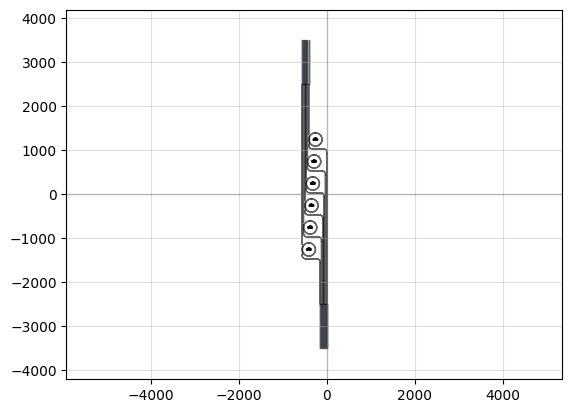

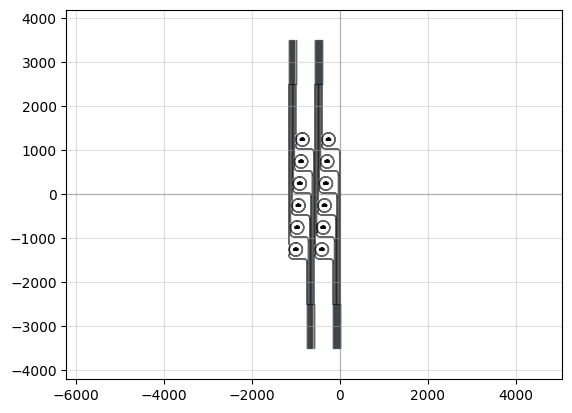

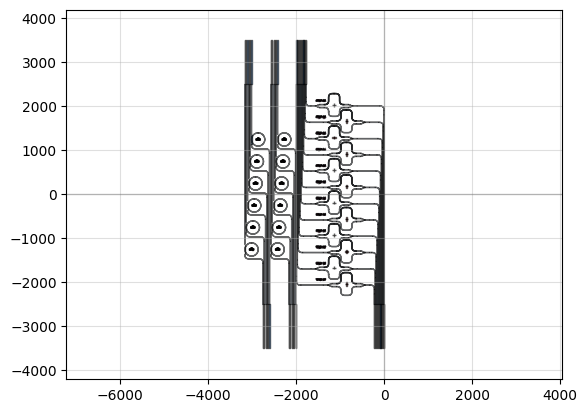

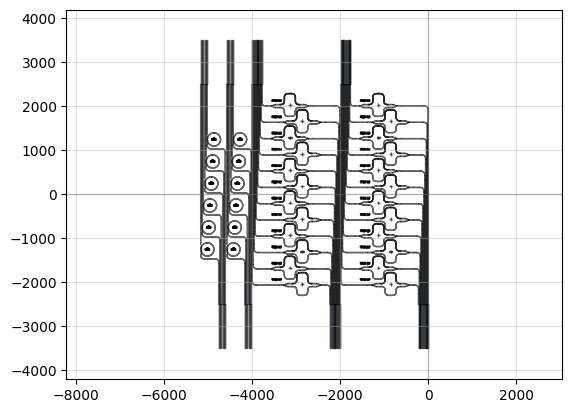

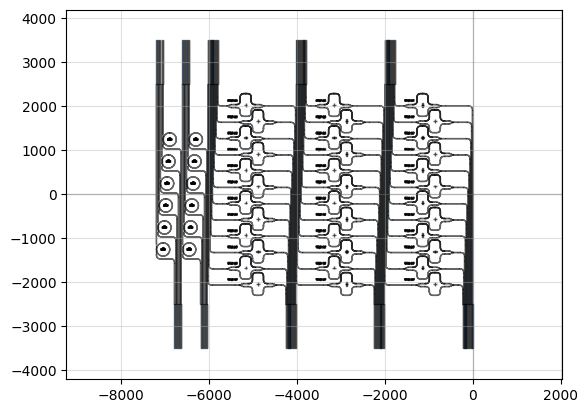

l_max 3.3333333333333335
Base length 9.333333333333332
seg num
2


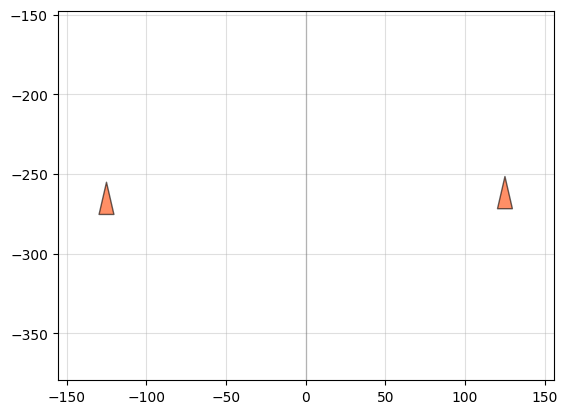

seg num
3


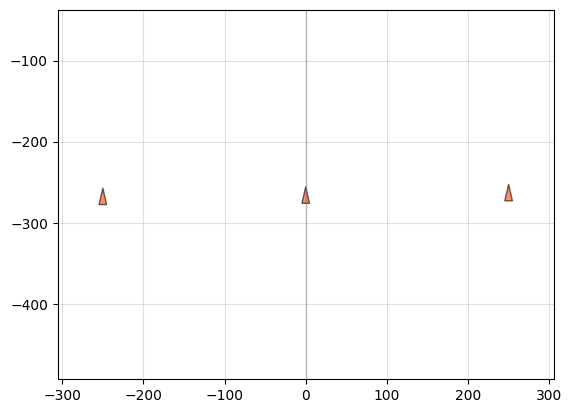

seg num
2


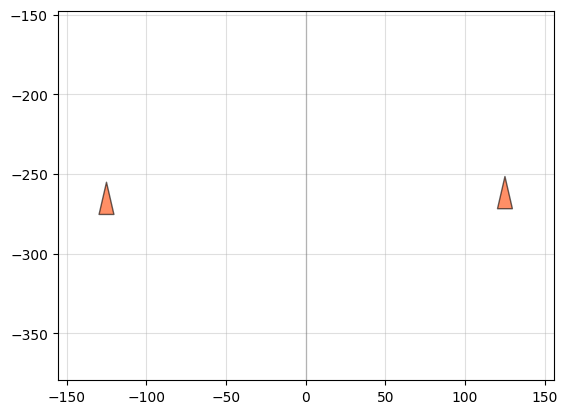

seg num
3


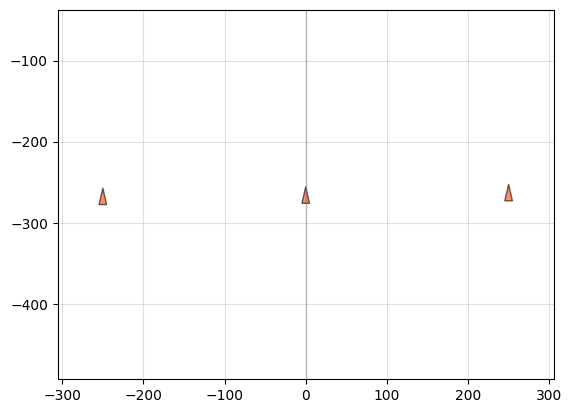

seg num
2


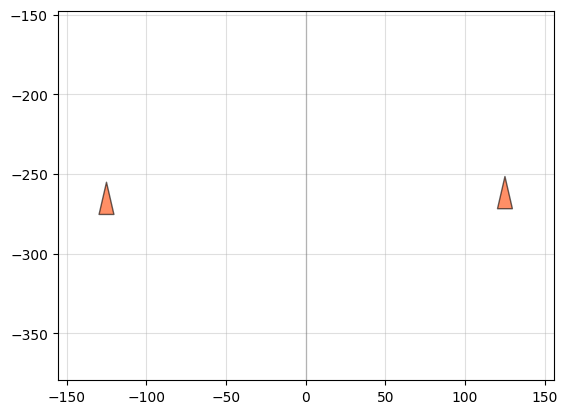

seg num
3


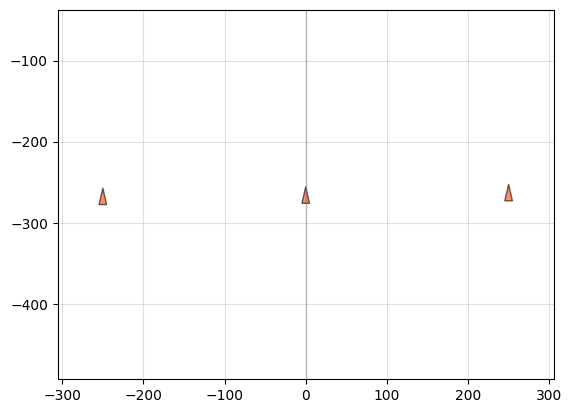

seg num
2


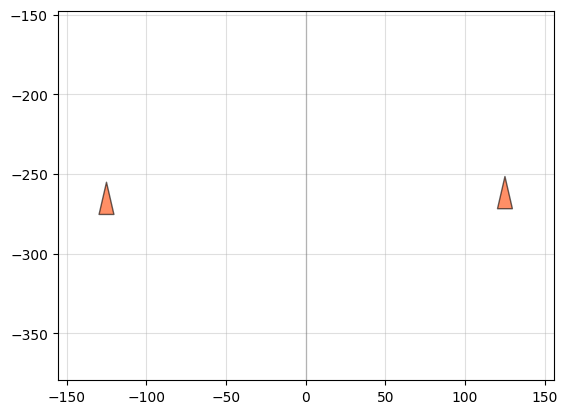

seg num
3


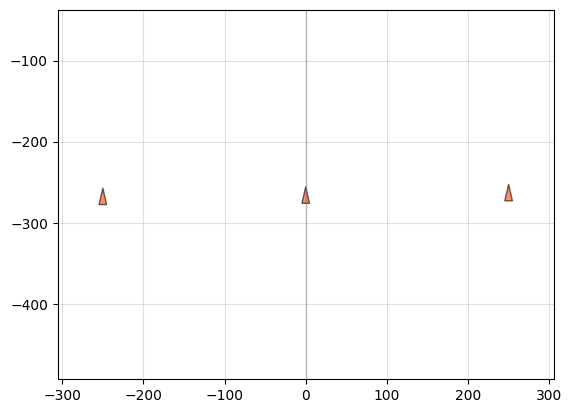

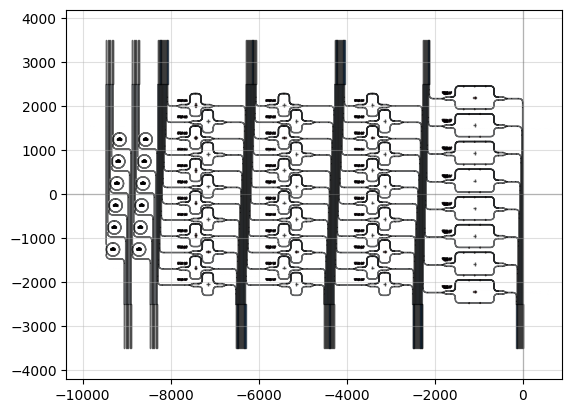

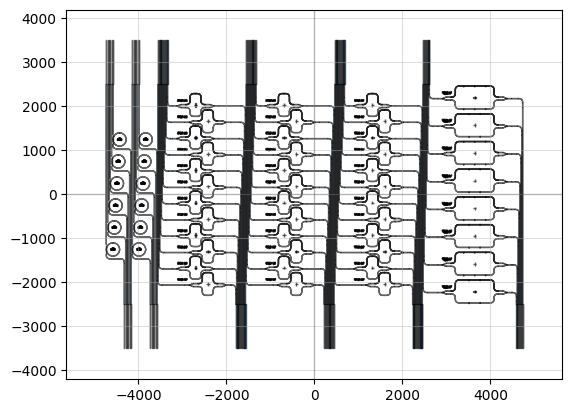

In [ ]:
def create_chip_matrix(row,col):

    # Initialize the main device
    D = Device('Y_AsymAM_Chip')
    
    ######################### Facet variables
    facet_y_pos = (chip_sizey-facet_length)/2#((row*dev_pitch_y)/2 + 300)

    # Loop to create a nxm matrix of Y_AsymAM devices
    for m in range(col+2): # 0 through col+1 (col 0 and 1 are test rings)
        

        if m == 0 or m == 1:
            Rings = Device()
            #testrings
            Tring_radius=150
            Tring_bend_radius=100
            Tring_wg_single=0.8
            Tring_wg_ring1=1.2
            Tring_wg_ring2=1.6
            Tring_step=30
            Tring_step2=65
            Tring_dev_pitch_y2=500
            Tring_width = 412
            Tring_xoffset1=0
            Hpath1 = 210

            num_l=6
            ll=0
            for ll in range(0,num_l):
                

                    #Test rings
                    ring1 = Rings.add_ref(ring_circle(radius = Tring_radius, width = Tring_wg_ring1, angle_resolution = 0.5, layer = layer_ring))
                    ring1.move([Tring_step*(ll)+Tring_xoffset1, (-(num_l - 1)/2+ll)*Tring_dev_pitch_y2])

                    left_turn2 = pp.euler(radius = Tring_bend_radius, angle = 90, p = 0.5, use_eff = True)
                    right_turn2 = pp.euler(radius = Tring_bend_radius, angle = -90, p = 0.5, use_eff = True)
                    cross_section_single = CrossSection().add(width = Tring_wg_single, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])

                    coupler1 = Rings.add_ref(coupler_straight(width = Tring_wg_single, length = Tring_radius*1.5, layer = layer_wg)).connect(port = 'coup', destination = ring1.ports['l']).move([-Tring_wgcp1[ll,0],0])
                    cross_section_single2 = CrossSection().add(width = facet_width1, offset = 0,  name = 'wg', layer = layer_wg, ports = ['1','2'])

                    wg_dev_out = Rings.add_ref(Path().append([
                            left_turn2, 
                            pp.straight(length = Hpath1),
                            right_turn2,
                            ]).extrude(cross_section_single)).connect('1', coupler1.ports['1'])
                    
                    facet_top = facet(coupler1, '2', 90, facet_y_pos, facet_length)
                    facet_bot = facet(wg_dev_out, '2', -90, -facet_y_pos, facet_length)

                    tap_top = connect_with_taper(facet_top,'f1', coupler1,'2', layer=layer_wg)
                    tap_bot = connect_with_taper(facet_bot,'f1', wg_dev_out,'2', layer=layer_wg)

                    #PCM
                    if(m==0):
                        angle = ll*8 + 13
                        print(angle)
                        pcm_ring = trapezoid(pi_len, 3.5, angle, layer = layer_pcm)
                        pcm_ring.center = [ring1.center[0], ring1.center[1]+150]  # Move bbox rectangle to the correct position
                        Rings.add_ref(pcm_ring)
                    
                    #Text
                    text0 = 'TRing ' + str(round(m+1, 4)) + ', ' + str(round(6-ll, 4))
                    text3 = 'wgcp ' + str(round(Tring_wgcp1[ll,0], 4)) + ' , radius ' + str(round(Tring_radius, 4))
                    text4 = 'BWidth ' + str(round(Tring_wg_single, 4)) + ' , RWidth' + str(round(Tring_wg_ring1, 4))

                    label_ring0 = Rings.add_ref(pg.text(text0, size = 7, justify = 'center', layer = layer_label))
                    label_ring0.center = [ring1.center[0], ring1.center[1] + 30]
                    label_ring1 = Rings.add_ref(pg.text(text3, size = 7, justify = 'center', layer = layer_label))
                    label_ring1.center = [label_ring0.center[0], label_ring0.center[1] -20]
                    label_ring2 = Rings.add_ref(pg.text(text4, size = 7, justify = 'center', layer = layer_label))
                    label_ring2.center = [label_ring0.center[0], label_ring0.center[1] -40]

                    Rings.add_ref(facet_top) # Coupler top facet
                    
                    Rings.add_ref(facet_bot) # Coupler bottom facet
                    Rings.add_ref(tap_top)
                    Rings.add_ref(tap_bot) # Coupler top facet

            xR, yR = get_dimension(Rings)
            Rings.center = [xR/2+Tring_step,0]
            D.add_ref(Rings)
            xD, yD = get_dimension(D)
            D.center=[-xD/2,0]
            qp(D)
            
        
        elif m == 2 or m == 3 or m == 4:
            # pi_len = 5 
            tot_len = 3*pi_len

            MZI_Col = Device()
            arm_len = 50
            stagger = 115 + arm_len/2
            dev_x, dev_y = get_dimension(Y_AsymAM())
            dev_pitch_x = dev_x/2 + 2*stagger + 10 + 100 + ws*(2*row-((row%2+1))) + 100 + 10 + dev_x/2 #4*500
            dev_pitch_y = dev_y/2 + 110
            for n in range(row):

                Mod1 = Y_AsymAM()

                ############################### ADD PCM
                if m < 4:
                    pcm_len = 0
                    pcm_wid = 4

                    if n != 0:
                        pcm_len = (n-1)*(tot_len-min_PCM_len)/(row - 2)+min_PCM_len
                        pcm_top_1 = trapezoid(pcm_len, pcm_wid, 45, layer = layer_pcm)
                        pcm_top_1.move([0, dev_y/2-wg_mod/2])  # Move bbox rectangle to the correct position
                        Mod1.add_ref(pcm_top_1)

                else:
                    pcm_len = tot_len
                    pcm_wid = 4

                    pcm_top = trapezoid(pcm_len, pcm_wid, 45, layer = layer_pcm)
                    pcm_top.move([0, dev_y/2-wg_mod/2])  # Move PCM to the correct position (on top MZI arm)
                    Mod1.add_ref(pcm_top)

                    
                # Position the device in the grid
                signed_stagger = (-1)**(n) * stagger
                step_x = signed_stagger

                step_y = (-(row - 1)/2 + n) * dev_pitch_y
                Mod1.move([step_x, step_y])  # Move the device to its position in the grid

                MZI_Col.add_ref(Mod1)


                ######################### LABEL DEVICES

                dev_label = f"PCM MZI Dev - ({(m-1)} , {(-n+row)}) \n PCM Length - {pcm_len} um"
                label_dev = MZI_Col.add_ref(pg.text(dev_label, size = 15, justify = 'center', layer = layer_label))
                label_dev.center = [step_x-300 - signed_stagger - stagger, step_y+100]

                ################################### Adding input/output turns for MZI
                
                y_output_len_left = 10 + (row-(row%2+1)-n)*ws + signed_stagger + stagger
                y_output_path_left= pp.straight(length = (y_output_len_left))

                AM_arm_input2= MZI_Col.add_ref(Path().append([
                y_output_path_left
                ]).extrude(NegativeTaper1)).connect('2', Mod1.ports['MZIin'])

                AM_arm_input3= MZI_Col.add_ref(Path().append([
                left_turn1
                ]).extrude(cross_section_multi)).connect('2', AM_arm_input2.ports['1'])

                AM_arm_input4= MZI_Col.add_ref(Path().append([
                Taperpath1
                ]).extrude(PositiveTaper1)).connect('2', AM_arm_input3.ports['1'])


                y_output_len_right = 10 + ws*(n) - signed_stagger + stagger
                y_output_path_right= pp.straight(length = (y_output_len_right))

                AM_arm_output2= MZI_Col.add_ref(Path().append([
                y_output_path_right
                ]).extrude(PositiveTaper1)).connect('1', Mod1.ports['MZIout'])

                AM_arm_output3= MZI_Col.add_ref(Path().append([
                right_turn1
                ]).extrude(cross_section_multi)).connect('1', AM_arm_output2.ports['2'])

                AM_arm_output4= MZI_Col.add_ref(Path().append([ # section right after turn
                Taperpath1
                ]).extrude(NegativeTaper1)).connect('1', AM_arm_output3.ports['2'])


                ######################### ADD FACETS

                facet_top = facet(AM_arm_input4, '2', 90, facet_y_pos, facet_length) # MZI top (left) facet
                facet_bot = facet(AM_arm_output4, '2', -90, -facet_y_pos, facet_length) # MZI bottom (right) facet

                tap_top = connect_with_taper(facet_top,'f1', AM_arm_input4,'1', layer=layer_wg) # MZI top (left) facet connection
                tap_bot = connect_with_taper(facet_bot,'f1', AM_arm_output4,'2', layer=layer_wg) # MZI bottom (right) facet connection

                MZI_Col.add_ref(facet_top)
                MZI_Col.add_ref(facet_bot)
                MZI_Col.add_ref(tap_top)
                MZI_Col.add_ref(tap_bot)

            xM, yM = get_dimension(MZI_Col)
            MZI_Col.center = [xM/2+ws-facet_width,0]
            D.add_ref(MZI_Col)
            xD, yD = get_dimension(D)
            D.center=[-xD/2,0]
            qp(D)


        else: # m == 5 
            MZI_Col = Device()
            # pi_len = 5
            tot_len = pi_len

            spacer = 150 # CHANGE LATER TO 1.5mm = 1500
            arm_len = 4*spacer+80
            dev_x, dev_y = get_dimension(Y_AsymAM(arm_len))
            dev_pitch_x = 10 #dev_x/2 + 2*stagger + 10 + 100 + ws*(2*row-((row%2+1))) + 100 + 10 + dev_x/2 #4*500
            dev_pitch_y = dev_y + 110
            min_seg = 2
            max_seg = seg_row/2 + 1
            segment_num = 0

            # Parameters
            h = 3
            l_max = 2 * (tot_len) / (2**2 - 1)
            print(f"l_max {l_max}")
            angle = 45  # Degrees
            base_len = l_max + 2 * h * np.tan(np.radians(angle))
            print(f"Base length {base_len}")
            
            for n in range(seg_row):

                Mod1 = Y_AsymAM(arm_len)
                PCM_array_top = Device()
                PCM_array_bot = Device()

                ######################### ADD PCM

                # segment_num = int(n/2)+2 # Create 3 modulators with 2, 3, 4, and 5 pcm secments


                # Create 2 modulators with 2, 3, 4, and 5 pcm secments
                # if n < seg_row/2:
                #     segment_num = (n%2)*min_seg+((n+1)%2)*max_seg + (-1)**(n+1)
                # else:
                #     segment_num = (n%2)*max_seg+((n+1)%2)*min_seg

                segment_num = (n%2)+2
                print('seg num')
                print(segment_num)
                tot_len
                pcm_wid = 4
                unit_len = tot_len/(2**segment_num-1) # this is the length of the smallest PCM segment

                # print(segment_num)

                for s in range(int(segment_num)): # 0 1, 0 1 2, 0 1 2 3, 0 1 2 3 4
                    ln = unit_len*2**s # desired width

                    # pcm_top = trapezoid(ln, pcm_wid, 45, layer = layer_pcm)
                    pcm_top, h_t = triangle(base_len, 13, layer = layer_pcm)
                    y_move = tri_displace(pcm_top, ln)
                    # print(h_t)
                    pcm_top.move([0, dev_y/2-y_move-wg_mod/2])  # Move PCM to the correct position (on top MZI arm) dev_y/2
                    PCM_array_top.add_ref(pcm_top)

                    # test,poo = triangle(base_len, 45, layer = layer_pcm)
                    # pcm_bot, y_move = add_horizontal_line(test, ln)

                    pcm_bot, h_t = triangle(base_len, 13, layer = layer_pcm)
                    y_move = tri_displace(pcm_top, ln)

                    # allign = pg.rectangle(size=(ln, 15), layer = layer_pcm)
                    # allign.center = [0,5]
                    # pcm_bot.add_ref(allign)

                    pcm_bot.move([0, -dev_y/2+wg_mod/2-y_move])  # Move PCM to the correct position (on top MZI arm)
                    PCM_array_bot.add_ref(pcm_bot)

                # Space the devices in the x direction
                PCM_array_top.distribute(elements = 'all', direction = 'x', spacing = 250, separation = False, edge = 'x')
                PCM_array_bot.distribute(elements = 'all', direction = 'x', spacing = 250, separation = False, edge = 'x')

                # Get the bounding box of the distributed array
                bbox = PCM_array_top.bbox  # [[x_min, y_min], [x_max, y_max]]
                x_min, y_min = bbox[0]
                x_max, y_max = bbox[1]

                # Calculate the center of the array along the x-axis
                x_center = (x_min + x_max) / 2
                PCM_array_top.move([-x_center, 0])  # Shift only in the x-axis
                PCM_array_bot.move([-x_center, 0])  # Shift only in the x-axis

                qp(PCM_array_bot)

                Mod1.add_ref(PCM_array_top)
                Mod1.add_ref(PCM_array_bot)

    
                

                step_y = (-(seg_row - 1)/2 + n) * dev_pitch_y

                Mod1.move([0, step_y])  # Move the device to its position in the grid

                MZI_Col.add_ref(Mod1)

                ######################### LABEL DEVICES

                dev_label = f"PCM MZI Dev - ({(m-1)} , {(-n+seg_row)}) \n PCM Length - {pcm_len} um \n Segments - {int(segment_num)}"
                label_dev = MZI_Col.add_ref(pg.text(dev_label, size = 15, justify = 'center', layer = layer_label))
                label_dev.center = [step_x-arm_len/2-150, step_y+100]

                ################################### Adding input/output turns for MZI
                
                y_output_len_left = 10 + (row-(row%2+1)-n)*ws
                y_output_path_left= pp.straight(length = (y_output_len_left))

                AM_arm_input2= MZI_Col.add_ref(Path().append([
                y_output_path_left
                ]).extrude(NegativeTaper1)).connect('2', Mod1.ports['MZIin'])

                AM_arm_input3= MZI_Col.add_ref(Path().append([
                left_turn1
                ]).extrude(cross_section_multi)).connect('2', AM_arm_input2.ports['1'])

                AM_arm_input4= MZI_Col.add_ref(Path().append([
                Taperpath1
                ]).extrude(PositiveTaper1)).connect('2', AM_arm_input3.ports['1'])

                y_output_len_right = 10 + ws*(n)
                y_output_path_right= pp.straight(length = (y_output_len_right))

                AM_arm_output2= MZI_Col.add_ref(Path().append([
                y_output_path_right
                ]).extrude(PositiveTaper1)).connect('1', Mod1.ports['MZIout'])

                AM_arm_output3= MZI_Col.add_ref(Path().append([
                right_turn1
                ]).extrude(cross_section_multi)).connect('1', AM_arm_output2.ports['2'])

                AM_arm_output4= MZI_Col.add_ref(Path().append([ # section right after turn
                Taperpath1
                ]).extrude(NegativeTaper1)).connect('1', AM_arm_output3.ports['2'])

                ######################### ADD FACETS

                facet_top = facet(AM_arm_input4, '2', 90, facet_y_pos, facet_length) # MZI top (left) facet
                facet_bot = facet(AM_arm_output4, '2', -90, -facet_y_pos, facet_length) # MZI bottom (right) facet

                tap_top = connect_with_taper(facet_top,'f1', AM_arm_input4,'1', layer=layer_wg) # MZI top (left) facet connection
                tap_bot = connect_with_taper(facet_bot,'f1', AM_arm_output4,'2', layer=layer_wg) # MZI bottom (right) facet connection

                MZI_Col.add_ref(facet_top)
                MZI_Col.add_ref(facet_bot)
                MZI_Col.add_ref(tap_top)
                MZI_Col.add_ref(tap_bot)

            xM, yM = get_dimension(MZI_Col)
            MZI_Col.center = [xM/2+ws-facet_width,0]
            D.add_ref(MZI_Col)
            xD, yD = get_dimension(D)
            D.center=[-xD/2,0]
            qp(D)

    D.center=[0,0]



    return D

# Run the function to create the matrix
D = create_chip_matrix(mrow,mcol)

# Get the bounding box of the device
bbox = D.bbox

# Calculate the width and length of the device
array_sizex = bbox[1][0] - bbox[0][0]  # x2 - x1
array_sizey = bbox[1][1] - bbox[0][1]  # y2 - y1

qp(D)

Device width: 15000
Device length: 6000


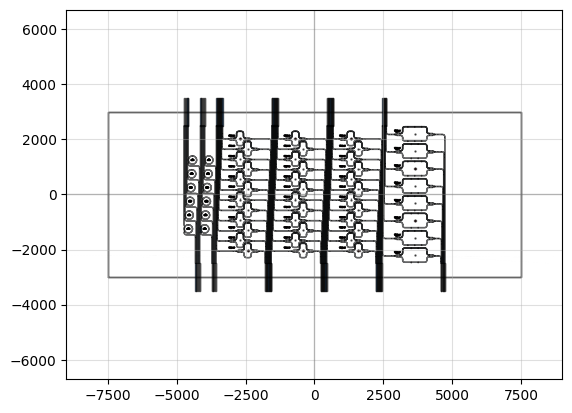

In [ ]:
# Get the bounding box of the device
bbox = D.bbox

# Print the size of the device
print(f"Device width: {chip_sizex}")
print(f"Device length: {chip_sizey}")

#Deep etching mask
Etchwidth=10
Rec = Device()
Detchmask1= Rec.add_ref(pg.rectangle(size = (chip_sizex-Etchwidth, chip_sizey-Etchwidth), layer = layer_Detch))
Detchmask2 = D.add_ref(pg.outline(Rec, distance = Etchwidth, precision = 1e-6, layer = layer_Detch))
Detchmask2.center=[0,0]

qp(D)

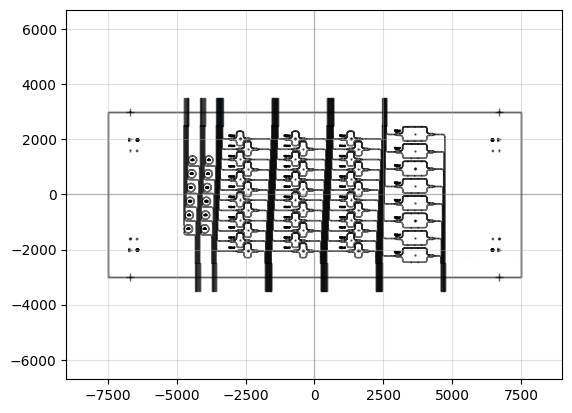

In [ ]:
#EBL markers

x_border = 800

marker1_x = chip_sizex/2 - x_border
marker1_y = chip_sizey/2 - 800

# marker_dice_x = chip_sizex/2-8000
# marker_dice_y = chip_sizey/2-2000

marker2_x = marker1_x - 250
marker2_y = marker1_y - 200

marker3_y = marker2_y - 200
marker4_y = marker3_y - 200
marker5_y = marker1_y + 200



D13 = Device()

D13.add_ref(marker_dice_array(marker_x = chip_sizex/2-x_border, marker_y = chip_sizey/2, layer = layer_marker)) # border cross

D.add_ref(D13)

D12 = Device()

D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker1_y,arm_length = 10, arm_width = 20, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker2_x, marker_y = marker1_y,arm_length = 5, arm_width = 10, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker3_y,arm_length = 10, arm_width = 20, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker2_x, marker_y = marker3_y,arm_length = 5, arm_width = 10, layer = layer_marker))
D12.add_ref(marker1_array(marker_x = marker1_x, marker_y = marker4_y,arm_length = 50, arm_width = 5, layer = layer_marker))
D12.add_ref(inv_marker1_array(marker_x = marker2_x, marker_y = marker4_y,arm_length = 10, arm_width = 2, layer = layer_marker))
D12.add_ref(calipermarker_array(marker_x = marker1_x, marker_y = marker2_y, arm_length = 50, arm_width=2, num_notches=7, layer1= layer_marker, layer2=layer_test))
D12.add_ref(DLalignmarker_array(marker_x = marker2_x, marker_y = marker2_y, arm_length = 40, layer1= layer_marker, layer2=layer_test))

D.add_ref(D12)

qp(D)

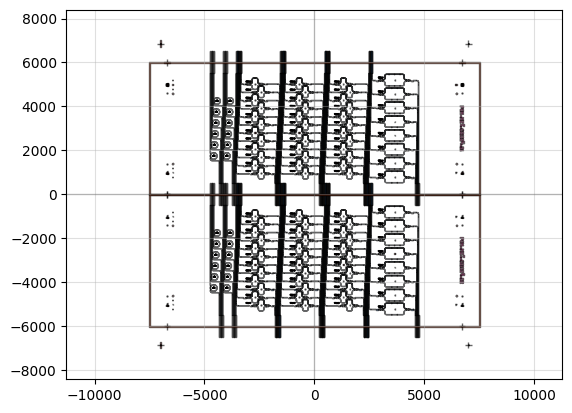

In [ ]:
D2 = pg.copy(D)

# device name
dev_name = 'PCM_MZI_021324'

label_dev = D.add_ref(pg.text(dev_name+'_D1', size = 150, justify = 'center', layer = layer_label))
label_dev.rotate(-90)
label_dev.center = [chip_sizex/2-x_border,0]

label_dev = D2.add_ref(pg.text(dev_name+'_D2', size = 150, justify = 'center', layer = layer_label))
label_dev.rotate(-90)
label_dev.center = [chip_sizex/2-x_border,0]

pos_x = 0
pos_y = -(chip_sizey)
D2.move((pos_x, pos_y))
D.add_ref(D2)
D.center=[0,0]

D.add_ref(marker_dice_array(marker_x = chip_sizex/2-500, marker_y = chip_sizey+500+350, layer = layer_marker))

qp(D)

In [ ]:
file_name = dev_name +'.gds'

D.flatten()
pattern_area = D.area()*10**-6 # unit mm^2

D.write_gds(file_name,
             unit = 1e-6, precision = 1e-10)
print(file_name)
print('pattern area = %.3f mm^2' % pattern_area)
print('GDS saved')

PCM_MZI_021324.gds
pattern area = 3.938 mm^2
GDS saved
